<a href="https://colab.research.google.com/github/iscanegemen/Machine-Learning-Applied-to-Weather-Forecasting/blob/master/Weather_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Applied to Weather Forecasting
Author: Egemen İşcan, Computer Engineering Undergraduate at Ozyegin University <br>
Contact: egemen.iscan@ozu.edu.tr <br>
GitHub Profile: <a href="https://github.com/iscanegemen">iscanegemen</a>

## Table of contents
* [Introduction](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Model Definition and Training](#model_training)
* [Model Evaluation](#model_evaluation)
* [Conclusion](#conclusion)

## Introduction <a name="introduction"></a>

The aim of this project is to build a time-series model using **Recurrent Neural Networks (RNNs)** in an attempt to forecast the temperature in **Istanbul** for the next 24 hours. This notebook is designed to serve as a tutorial on the subject, as well as a preparation for a much bigger project on time-series analysis which will hopefully be available on GitHub in the future.


## Data <a name="data"></a>


### Data Source and Use Case

When we first started preparing this notebook, we considered using <a href="https://www.kaggle.com/vonline9/weather-istanbul-data-20092019">a dataset from Kaggle</a>. However, we then decided that it wasn't sufficient for our case since the measurements were made daily. What we needed instead was hourly measurements. But we used the same API that was also used to obtain the Kaggle dataset that we've mentioned. 

Our model will be trained using approximately 10 years of weather data for Istanbul city, obtained from the WorldWeatherOnline API. The data, which is in tabular format, consists of detailed hourly measurements and includes all the necessary information in order to make accurate predictions. A good way to begin our work would be preprocessing this data, so that it becomes suitable for training a **predictive forecasting model**.


### Initial Data Exploration and Feature Engineering

We will be using <a href="https://keras.io/">Keras</a> for our purpose. Keras is a user-friendly open-source library used for working with Machine Learning models and runs on top of <a href="https://www.tensorflow.org/about">Tensorflow</a> which is also a free and open-source software library that provides you with a framework for this purpose.

In [0]:
import tensorflow as tf

# Eager Execution offers an intuitive interface with easier debugging and natural control flow.
tf.compat.v1.enable_eager_execution() 

Let's load and explore the data frame.

In [0]:
# Import pandas to load the data.
import pandas as pd
df = pd.read_csv("istanbul.csv")

# Display the first ten rows of the data frame.
df.head(10)

,date_time,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,uvIndex.1,moon_illumination,moonrise,moonset,sunrise,sunset,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
0,2009-01-01 00:00:00,5,2,0.0,8.7,1,0,31,11:09 AM,10:39 PM,08:29 AM,05:47 PM,2,-1,3,-1,21,100,96,0.0,1031,3,10,353,13
1,2009-01-01 01:00:00,5,2,0.0,8.7,1,0,31,11:09 AM,10:39 PM,08:29 AM,05:47 PM,2,0,3,0,17,100,96,0.0,1031,3,10,344,11
2,2009-01-01 02:00:00,5,2,0.0,8.7,1,0,31,11:09 AM,10:39 PM,08:29 AM,05:47 PM,2,1,3,1,13,99,96,0.1,1030,3,9,335,8
3,2009-01-01 03:00:00,5,2,0.0,8.7,1,0,31,11:09 AM,10:39 PM,08:29 AM,05:47 PM,2,2,3,2,9,99,96,0.1,1030,3,9,326,6
4,2009-01-01 04:00:00,5,2,0.0,8.7,1,0,31,11:09 AM,10:39 PM,08:29 AM,05:47 PM,2,1,3,1,11,90,95,0.0,1030,2,9,312,7
5,2009-01-01 05:00:00,5,2,0.0,8.7,1,0,31,11:09 AM,10:39 PM,08:29 AM,05:47 PM,2,0,3,0,13,81,94,0.0,1029,2,10,297,8
6,2009-01-01 06:00:00,5,2,0.0,8.7,1,0,31,11:09 AM,10:39 PM,08:29 AM,05:47 PM,1,0,2,0,15,72,94,0.0,1029,2,10,283,10
7,2009-01-01 07:00:00,5,2,0.0,8.7,1,1,31,11:09 AM,10:39 PM,08:29 AM,05:47 PM,2,0,3,0,14,64,92,0.0,1029,3,10,274,10
8,2009-01-01 08:00:00,5,2,0.0,8.7,1,2,31,11:09 AM,10:39 PM,08:29 AM,05:47 PM,2,1,3,1,14,56,90,0.0,1029,3,10,264,10
9,2009-01-01 09:00:00,5,2,0.0,8.7,1,2,31,11:09 AM,10:39 PM,08:29 AM,05:47 PM,2,1,4,1,13,48,89,0.0,1029,4,10,255,10


Before making any major modifications in the data frame, we need to save some of the most basic information concerning the data. We can use this information as a reference later on if something goes wrong while working on it.

In [0]:
# Format the date_time column and make it the index.
df.date_time = pd.to_datetime(df['date_time']).dt.strftime('%m/%d/%Y,  %H:%M')
df.index = df['date_time']

# Extract the number of rows and columns by using the shape of the data.
numRows,numColumns = df.shape
# Extract the time interval.
last_date, first_date = df.iloc[0].date_time, df.iloc[-1].date_time
# Check the availability of the data.
na_cols = df.columns[df.isna().any()].tolist()

# Print the information.
print(f"There are {numRows} rows and {numColumns} columns in the initial dataset.")
print(f"The data represents the time frame between the dates '{last_date}' and '{first_date}'.")
if not na_cols:
  print("There are no NA rows.")
else:
  print(f"Columns in the dataset which include NA rows: {na_cols}.") 

There are 87672 rows and 25 columns in the initial dataset.
The data represents the time frame between the dates '01/01/2009,  00:00' and '01/01/2019,  23:00'.
There are no NA rows.


As you can see, the output of the cell above includes significant information about the time frame and the shape of our data. In the next cell, we remove all the columns which may not be converted to type "float64". Any other data type than this (including strings) is not related to the training process of our model and therefore shall be omitted.

In [0]:
# Iterate over each column in df and try to convert its type to float if it's convertible. 
# Otherwise remove the column from the data frame.

for column in df:
  try:
    df[column] = df[column].astype('float')
  except:
    df.drop(column, axis=1, inplace=True)

# Display that all the remaining columns are of type 'float64'.
df.dtypes

maxtempC             float64
mintempC             float64
totalSnow_cm         float64
sunHour              float64
uvIndex              float64
uvIndex.1            float64
moon_illumination    float64
DewPointC            float64
FeelsLikeC           float64
HeatIndexC           float64
WindChillC           float64
WindGustKmph         float64
cloudcover           float64
humidity             float64
precipMM             float64
pressure             float64
tempC                float64
visibility           float64
winddirDegree        float64
windspeedKmph        float64
dtype: object

Before moving on to feature selection, it is good practice to check some statistical facts for our data set. Let's take our time to look for anything that seems suspicious and abnormal in the stats. One example of such a case would be a mean temperature of 462 degrees Celsius since this value on the surface of Venus would be okay, it is too high for and doesn't belong to our planet Earth. 

In [0]:
# Basic statistics about our data.
df.describe()

,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,uvIndex.1,moon_illumination,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
count,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.00000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000
mean,17.954010,13.661648,0.014974,10.392226,4.394197,2.292180,46.191897,10.823684,15.427879,16.701125,14.994217,26.18454,33.355416,72.272607,0.035785,1015.774546,15.670089,9.710147,121.158215,17.438954
std,7.567791,6.835875,0.168415,3.088057,1.674961,2.604715,31.248267,6.323005,9.247401,8.061735,8.703091,13.87182,32.862103,12.122126,0.201372,6.513332,7.275106,1.144828,96.594223,9.259504
min,-3.000000,-4.000000,0.000000,3.400000,1.000000,0.000000,0.000000,-10.000000,-13.000000,-4.000000,-13.000000,0.00000,0.000000,24.000000,0.000000,989.000000,-4.000000,0.000000,0.000000,0.000000
25%,12.000000,8.000000,0.000000,8.700000,3.000000,0.000000,19.000000,6.000000,8.000000,10.000000,8.000000,15.00000,6.000000,64.000000,0.000000,1012.000000,10.000000,10.000000,43.000000,10.000000
50%,18.000000,14.000000,0.000000,11.100000,4.000000,0.500000,46.000000,11.000000,16.000000,16.000000,16.000000,25.00000,20.000000,73.000000,0.000000,1015.000000,15.000000,10.000000,71.000000,16.000000
75%,25.000000,20.000000,0.000000,11.600000,6.000000,5.000000,73.000000,16.000000,24.000000,25.000000,22.000000,35.00000,56.000000,81.000000,0.000000,1020.000000,22.000000,10.000000,207.000000,23.000000
max,37.000000,26.000000,4.700000,14.500000,7.000000,9.000000,100.000000,27.000000,42.000000,42.000000,39.000000,117.00000,100.000000,100.000000,6.600000,1041.000000,37.000000,10.000000,360.000000,69.000000


We have to know how different columns relate to each other. We will use the *Pearson Correlation Coefficient* for this step. We don't want to include all the columns because it is important to use as few variables as possible during training. This will improve the accuracy of our model as well as reduce training time and the amount of information loss.

In [0]:
# Correlation between each feature and the temperature.
df.corr('pearson').tempC

maxtempC             0.957447
mintempC             0.955168
totalSnow_cm        -0.162765
sunHour              0.666122
uvIndex              0.928803
uvIndex.1            0.462494
moon_illumination    0.008625
DewPointC            0.918840
FeelsLikeC           0.986279
HeatIndexC           0.990209
WindChillC           0.985344
WindGustKmph        -0.062864
cloudcover          -0.488978
humidity            -0.444329
precipMM            -0.061571
pressure            -0.418857
tempC                1.000000
visibility           0.219649
winddirDegree       -0.178527
windspeedKmph       -0.046521
Name: tempC, dtype: float64

### Feature Selection and Scaling

Choosing the correct features for later usage during the training process and scaling the dataset beforehand are crucial in order to obtain better results. 

First, we will be creating a new data frame containing only the features that we believe are non-trivial for our project: 

*   DewPointC
*   tempC
*   maxtempC
*   mintempC
*   WindChillC
*   humidity
*   pressure
*   visibility
*   cloudcover
*   precipMM
*   totalSnow_cm
*   WindGustKmph
*   winddirDegree
*   windspeedKmph

Of course, some features can be added or removed for a more accurate model but these features will do our job for the moment. After we're done with that, we'll scale the new dataset. Let's go.

In [0]:
# The following libraries are used for data manipulation and visualization.
import matplotlib.pyplot as plt
from matplotlib import pylab
%matplotlib inline
import numpy as np

# Change the style of the graphs. This is optional.
plt.style.use('dark_background')

After importing the necessary libraries, we will now plot a graph showing us once more, but this time more clearly, how the features correlate. 

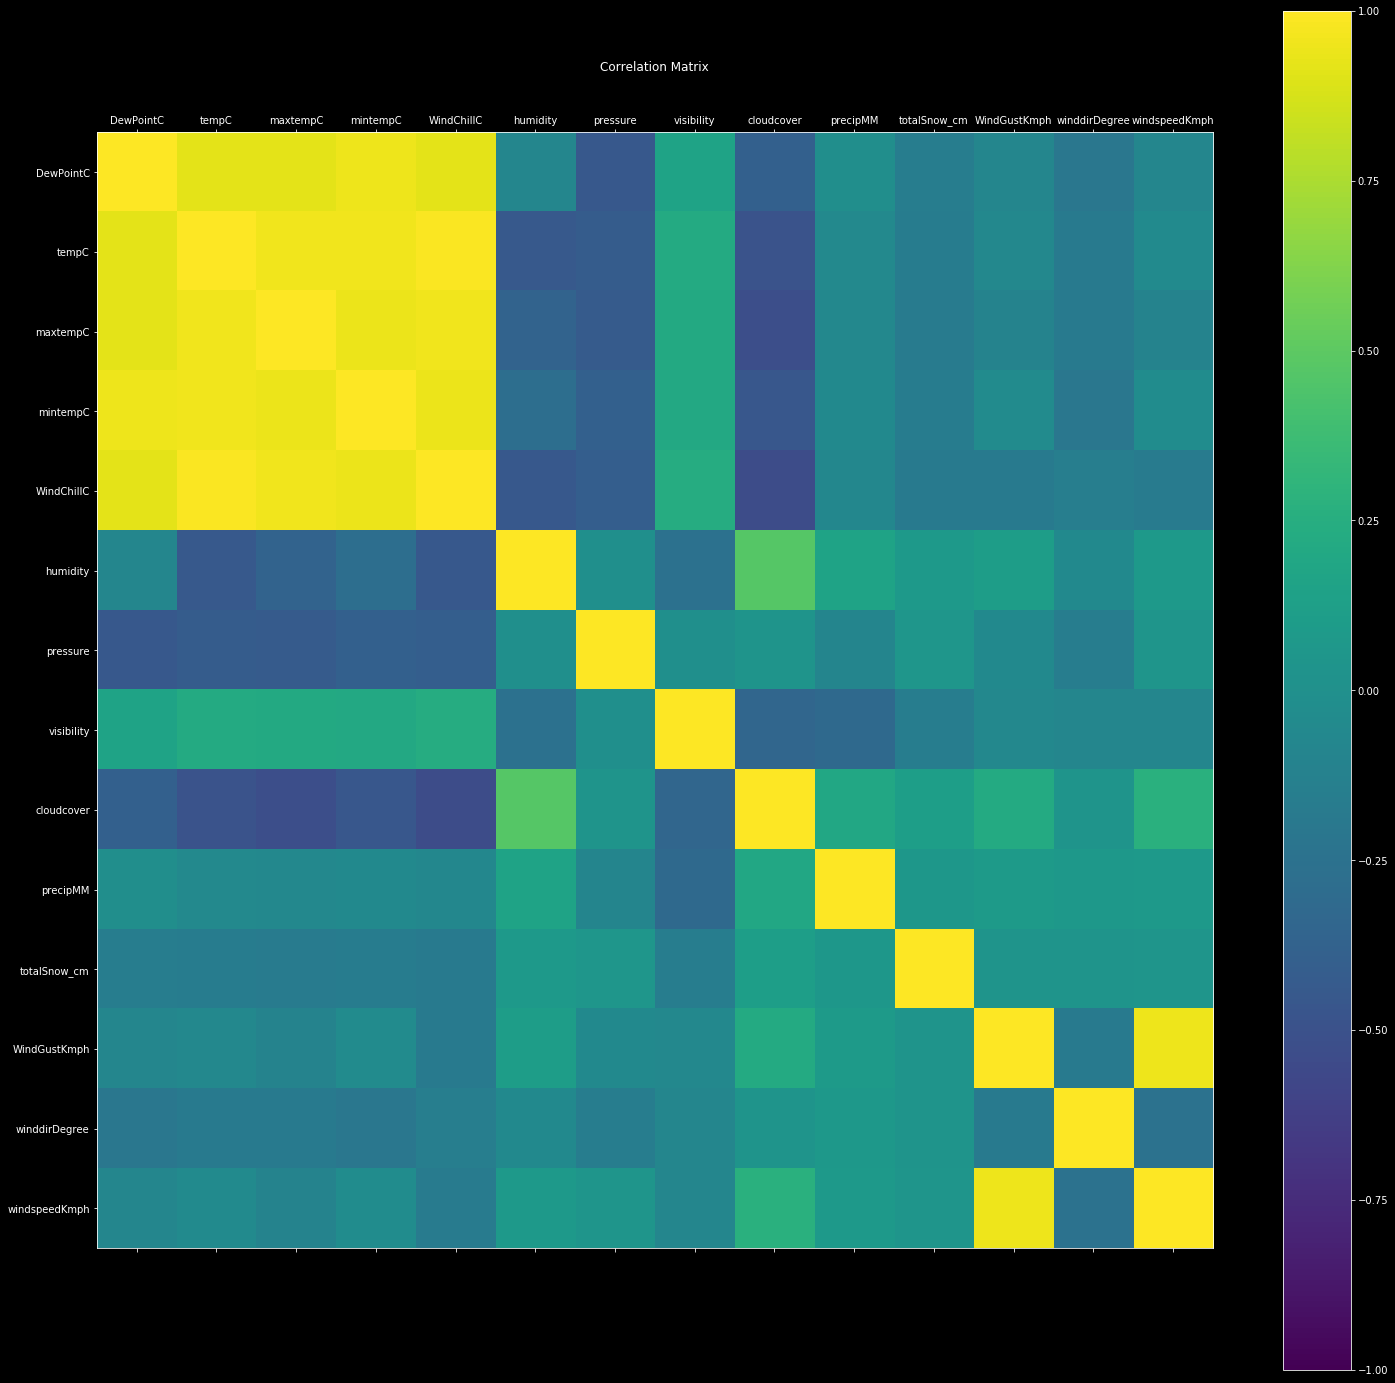

In [0]:
# Create a new variable containing the selected features to continue with.
features = df[['DewPointC','tempC','maxtempC','mintempC','WindChillC',
               'humidity','pressure','visibility','cloudcover','precipMM',
               'totalSnow_cm','WindGustKmph','winddirDegree','windspeedKmph']]

# Visualize the correlation matrix.
fig = plt.figure(figsize=(25,25)) 
ax = fig.add_subplot(111) # 1x1 grid, first subplot.
fig.colorbar(ax.matshow(features.corr(), vmin=-1, vmax=1)) 
ticks = np.arange(len(features.columns))
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(features.columns)
ax.set_yticklabels(features.columns)
plt.title("Correlation Matrix")

plt.show()

To verify that the features are in the correct format, let's plot graphs for each seperate feature and observe how they evolve over time. Below, you can notice that one of the variables, tempC, has obvious seasonality. We will talk about this later. 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa52f47d7f0>,
      dtype=object)

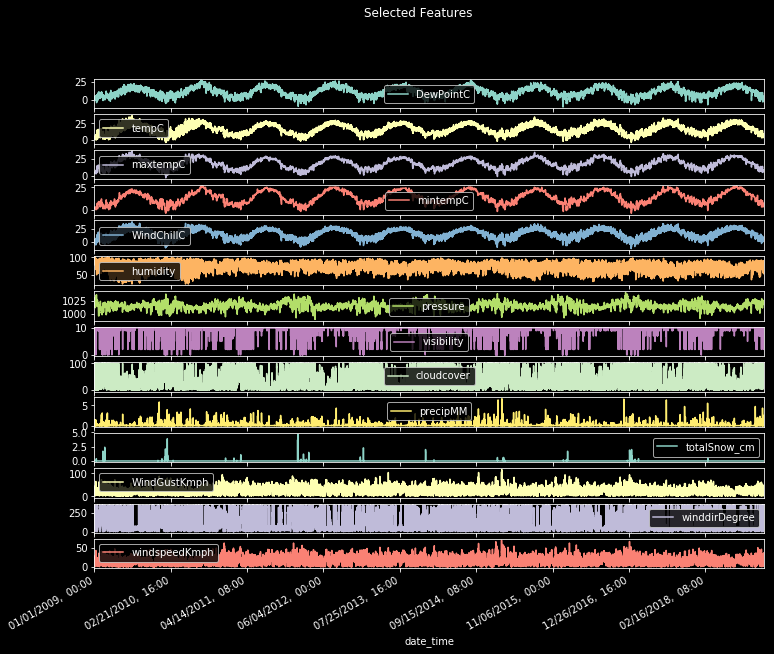

In [0]:
# Create a plot which shows how the selected features change over time.
features.plot(subplots=True,figsize=(12,10),title='Selected Features')

It is incredibly important to normalize the data set within the specified range. This may help the learning algorithm to work faster and more efficiently. MinMaxScaler is an algorithm which does exactly this. It transforms all the values and fits them in a range between 0 and 1.

In [0]:
# scikit-learn is a free software machine learning library. 
import sklearn
from sklearn.preprocessing import MinMaxScaler

# Scale the data using MinMaxScaler within the range 0 to 1 and assign the scaled data to a new variable.
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(features.values)


## Methodology <a name="methodology"></a>

In this project, we will try to build a model which learns from data in the form of time-series and then predicts the new timesteps. To achieve this, we will use RNNs because they are arguably the best type of machine learning algorithm for our case. Until this step, we have obtained the required data, cleaned and explored it and selected the appropriate features for training the model. Then we have eliminated some of the features after examining the Pearson correlation matrix. The reason we are not using all the features is that it would not increase model performance, on the contrary, it would decrease it because when we train an ML model which takes multivariate data as input, the learning algorithm applies feature reduction to the data and some information is lost in the course of this task. This situation is called the Curse of Dimensionality. We don't want too much data being lost, so we only choose the features that are essential for the objective. The following step of our project is the actual building/training process. Then we will evaluate the model using the appropriate methods.


## Model Definition and Training <a name="model_training"></a>

### Compiling the Model

It is recommended that you study the code for this step in true detail and understand how it works. 

First, we define two variables; "past" represents the number of hours our model will be able to look into the past and "future" represents the number of hours our model will predict into the future.  

We then define the **batch size** and the **train/test splitting point**. The *batch size* is a hyperparameter which represents the number of samples used before updating the model weights. After working with different batch sizes, we've decided to use 256 separate batches to train our model. We will use the SPLIT variable for splitting the data into train data and test data. In order to calculate the splitting point, we used; the batch size, the shape of our data and a test percentage of ~0.33.  

After we specify this information, we split the data into two separate parts using the splitting point. The first one is used for training the model and the rest is used as validation data. We also create a variable called "indices" which holds the index values of the test set for visualization.

In [0]:
# The model will be able to "see" the weather belonging to past 5 days (120 hours). 
past = 120
# The model should be able to forecast the temperature for the next 24 hours.
future = 24

BATCH_SIZE = 256
SPLIT = 58624

# Use list comprehensions for splitting the data into train and test sets.
x_train, y_train = map(np.array, zip(*[(dataset[range(k-past, k)], dataset[:,1][k:k+future]) for k in range(past, SPLIT)]))
x_test, y_test = map(np.array, zip(*[(dataset[range(k-past, k)], dataset[:,1][k:k+future]) for k in range(SPLIT+past, len(dataset)-future)]))

indices = [range(k-past, k+future, future) for k in range(SPLIT+past, len(dataset)-future)]

One of the most important things to pay attention to while forming the train and test sets is the fact that we are shuffling the training data before we feed it to the model. The reason for this is that the original data is nonstationary, meaning that it involves seasonality. Removing seasonality in a dataset to make it stationary, more often than not improves the model performance. If we wanted to, we could check whether our data was stationary or not by computing some statistical tests, such as KPSS and ADF. However, it would be beyond the scope of this project since this is an introductory notebook.

In [0]:
# Shuffle training data to remove seasonality.
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(10000).batch(BATCH_SIZE).repeat()

# Do NOT shuffle test data.
test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_data = test_data.batch(BATCH_SIZE).repeat()

Let's define and then compile the model. We start by adding two LSTM (a specialized RNN) layers to our model and a final Dense layer which is used to connect each input neuron to an output neuron and has the shape equal to the output dimension, i.e. the number of hours we want to predict. We decided to use <a href="https://www.researchgate.net/publication/323956667_Deep_Learning_using_Rectified_Linear_Units_ReLU">ReLU (Rectified Linear Units)</a> as our activation function, since it is particularly famous as it overcomes the Vanishing Gradient problem. It is also useful if you are a beginner as it's generally adaptable to many different cases.

In order to compile the model, we need to pass an optimizer as an argument to the *compile()* method. While there is no standard recipe for choosing a learning method for a model, RMSprop is an optimizer which uses an adaptive learning rate and it works generally well with big datasets. So we will go with that one. 

It is recommended that you don't modify the following cell a lot, unless you possess advanced knowledge of the domain.

In [0]:
# Define a Sequential Model.
model = tf.keras.models.Sequential()

# Add layers to the model. 
model.add(tf.keras.layers.LSTM(32, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(tf.keras.layers.LSTM(16, activation='relu'))
model.add(tf.keras.layers.Dense(future))

# Compile the model.
model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [0]:
# Display a summary representation of our model.
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 120, 32)           6016      
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense (Dense)                (None, 24)                408       
Total params: 9,560
Trainable params: 9,560
Non-trainable params: 0
_________________________________________________________________


### Training the Model

So, how do we fit the data into the model? While this step is pretty straightforward, there are some things you should pay attention to. First of all, you should specify the number of epochs, steps per epoch, validation data and validation steps arguments. You can increase the number of steps for better results. Another thing to keep in mind is that the fit() method also returns a complete history of the training process apart from doing the actual training task. We will assign a variable to this method for keeping a record of the training loss and the validation loss. 

When you execute the following cell, the training will begin and it is likely to take some time. If you don't want to wait, you can skip this step by adjusting the number of epochs and the number of steps per epoch or you can download the pre-trained model from GitHub and upload it to the notebook. 


In [0]:
# An epoch refers to a cycle through the training set.
EPOCHS = 20
# Since one entire cycle is too big in our case, use steps.
STEPS_PER_EPOCH = 1000

# Fit the data into the model.
hist = model.fit(train_data, epochs=EPOCHS,
                 steps_per_epoch=STEPS_PER_EPOCH,
                 validation_data=test_data,
                 validation_steps=500)

Train for 1000 steps, validate for 500 steps
Epoch 1/20
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
1000/1000 [==============================] - 616s 616ms/step - loss: 0.0670 - val_loss: 0.0392
Epoch 2/20
1000/1000 [==============================] - 612s 612ms/step - loss: 0.0315 - val_loss: 0.0286
Epoch 3/20
1000/1000 [==============================] - 607s 607ms/step - loss: 0.0274 - val_loss: 0.0282
Epoch 4/20
1000/1000 [==============================] - 605s 605ms/step - loss: 0.0257 - val_loss: 0.0252
Epoch 5/20
1000/1000 [==============================] - 605s 605ms/step - loss: 0.0243 - val_loss: 0.0256
Epoch 6/20
1000/1000 [==============================] - 607s 607ms/step - loss: 0.0238 - val_loss: 0.0231
Epoch 7/20
1000/1000 [==============================] - 611s 611ms/step - loss: 0.0229 - val_loss: 0.0227
Epoch 8/20
1000/1000 [==============================] - 619s 619ms/step - loss: 0.0223 - val_loss: 0.0228
Epoch 9/20
10

In [0]:
# PATH = '.../istanbul_weather_model.h5'
# model = tf.keras.models.load_model(PATH)

## Model Evaluation <a name="model_evaluation"></a>

If we train the model more than we should, the model starts hallucinating non-existent patterns and the accuracy starts to decrease instead of increasing, then we call this situation "**overfitting**". To detect this and prevent it from happening, we keep record of the loss functions during the training step. Since the size of our training set is pretty large, it is unlikely that we are overfitting but there is no harm in checking.

**NOTE:** If you are using the pre-trained model which is available on GitHub, this cell won't execute properly because there won't be any training history in that case.

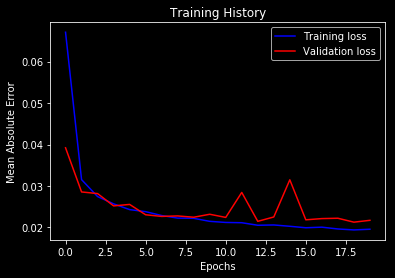

In [0]:
# Visualize a plot of loss on the training and validations sets over training epochs.

plt.figure()

plt.plot(range(len(hist.history['loss'])), hist.history['loss'], 'b', label='Training loss')
plt.plot(range(len(hist.history['val_loss'])), hist.history['val_loss'], 'r', label='Validation loss')
plt.title('Training History')
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error")
plt.legend()

plt.show()

We have chosen the *Root Mean Squared Error (RMSE)* as our evaluation metric. It is calculated by taking the square root of square of the difference between the test data and the predictions made by the model. What we are going to do is to take samples from the validation data and make predictions for each of them. We will plot our forecast and the real values on a graph. Finally, we will calculate the error and add that to the graph too. What's good about this metric is that it prevents large errors and in our case large errors are undesirable. Additionally, thanks to the existance of the square root in RMSE formula, the scale of errors is the same as the scale of target values. 

![RMSE Formula](https://community.qlik.com/legacyfs/online/128958_2016-06-23%2013_45_36-Root%20Mean%20Squared%20Error%20_%20Kaggle.png)


Finally, let's plot the predictions created by using the test data. We will look at these examples for evaluating the performance of our model. 

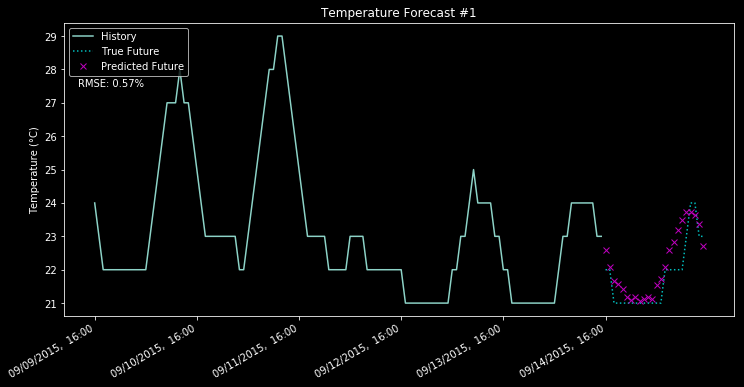

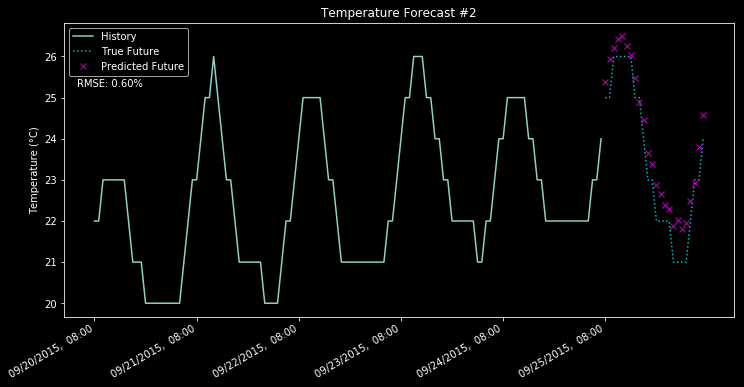

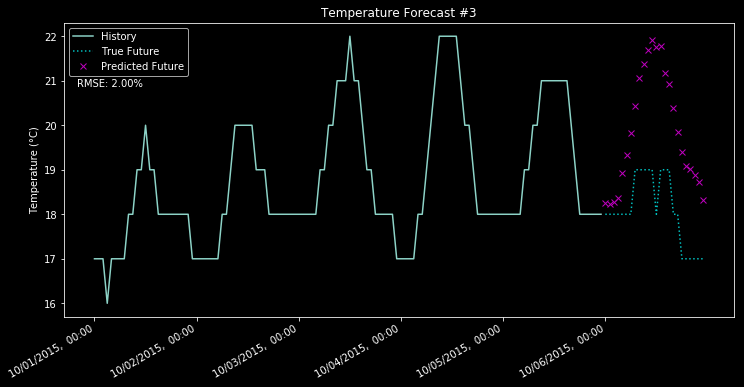

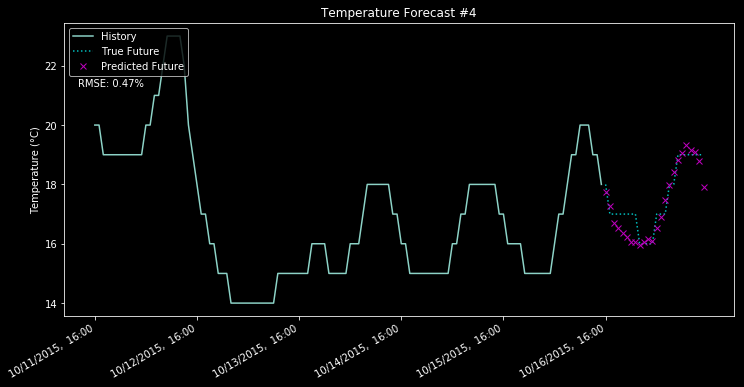

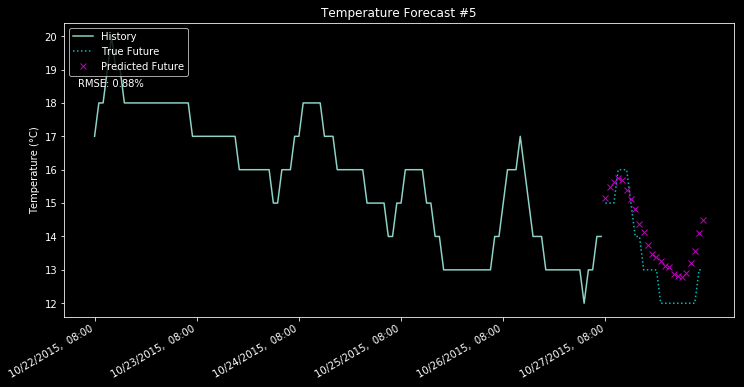

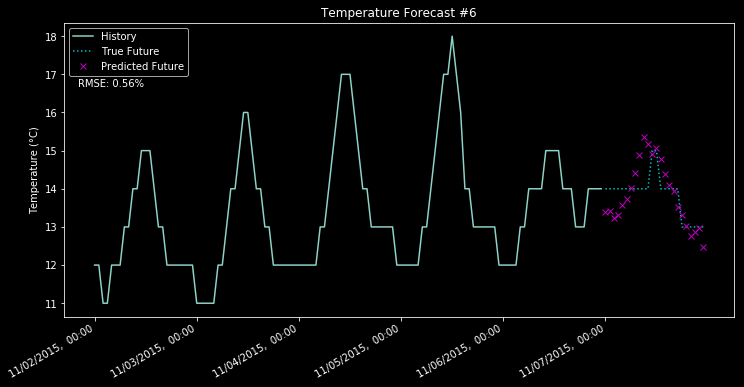

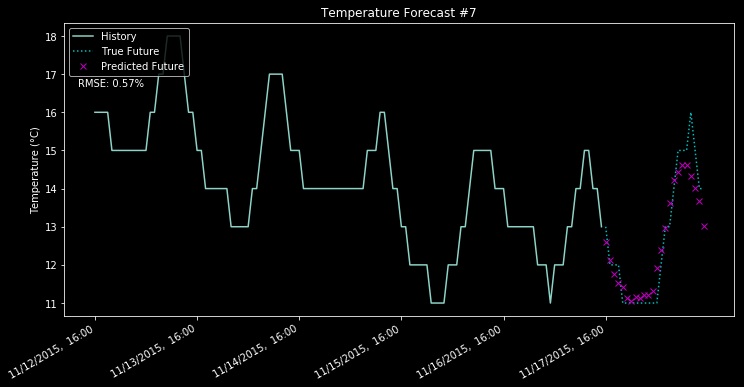

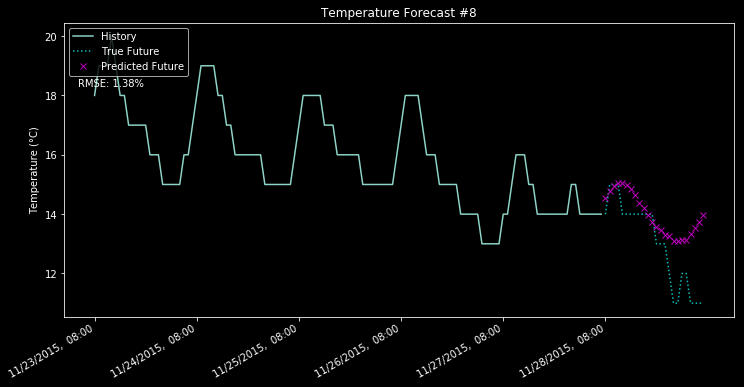

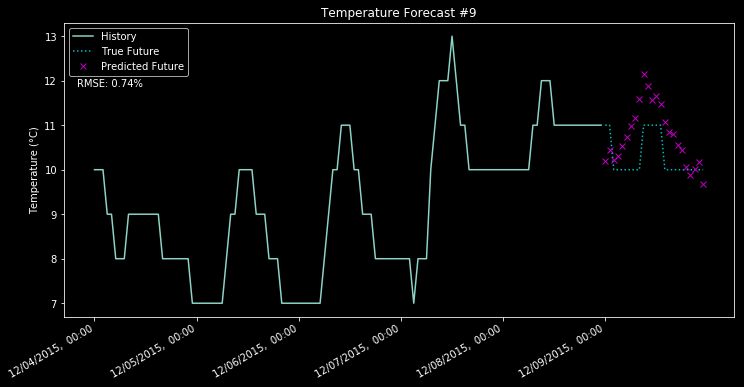

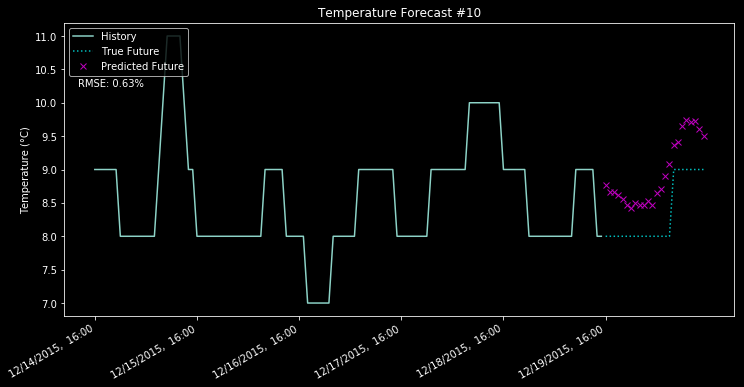

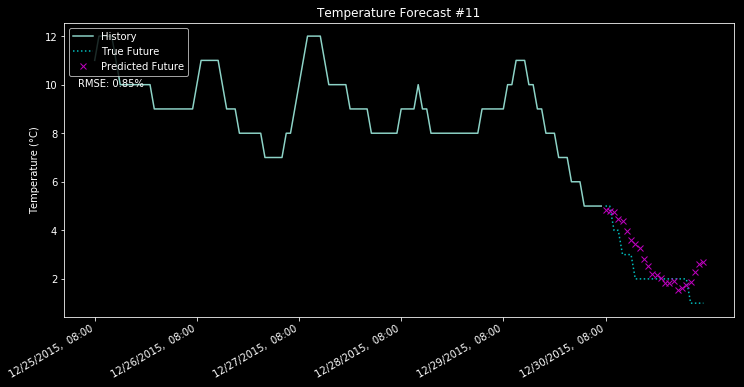

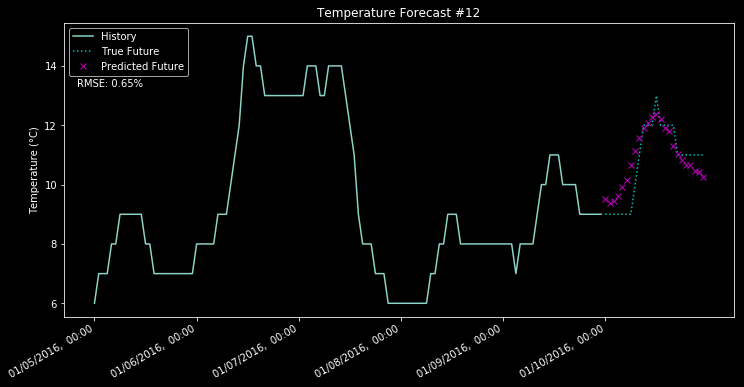

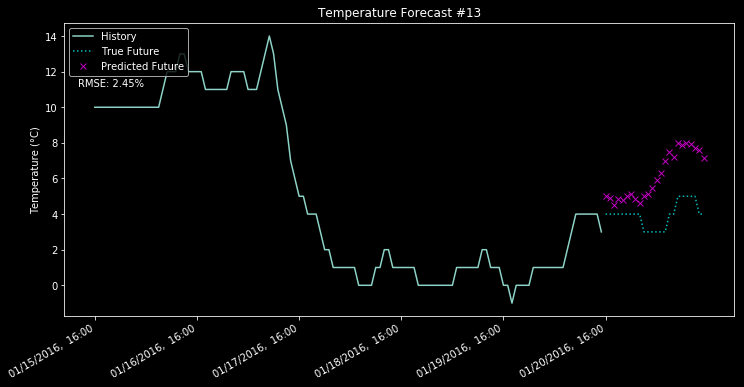

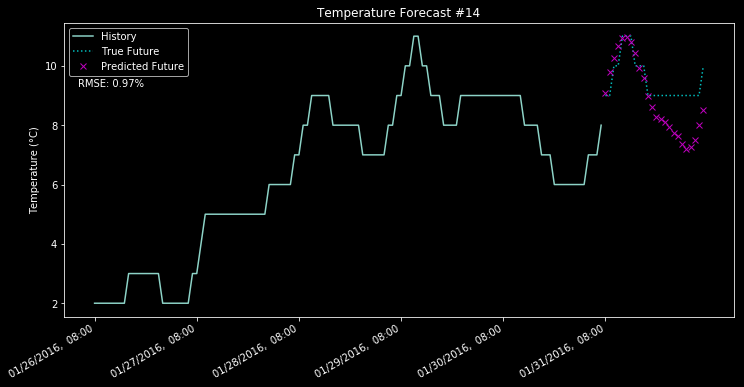

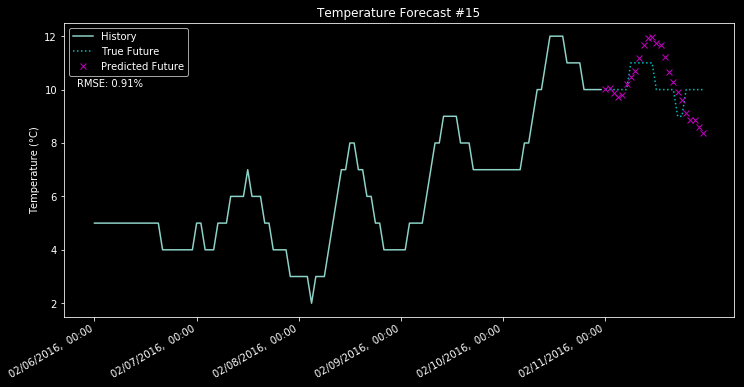

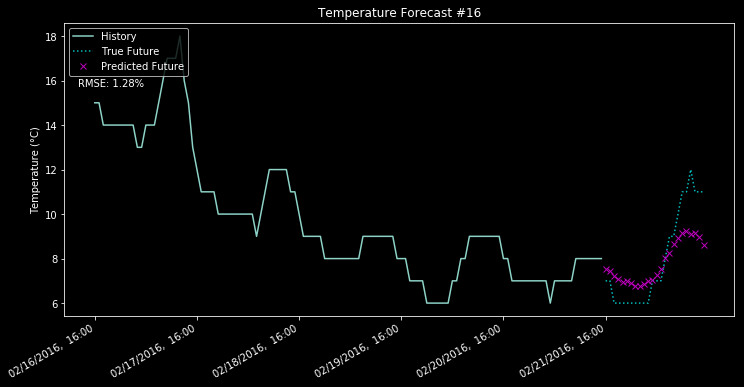

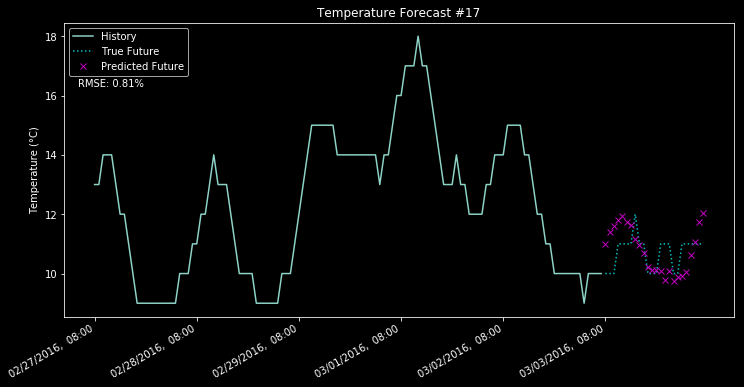

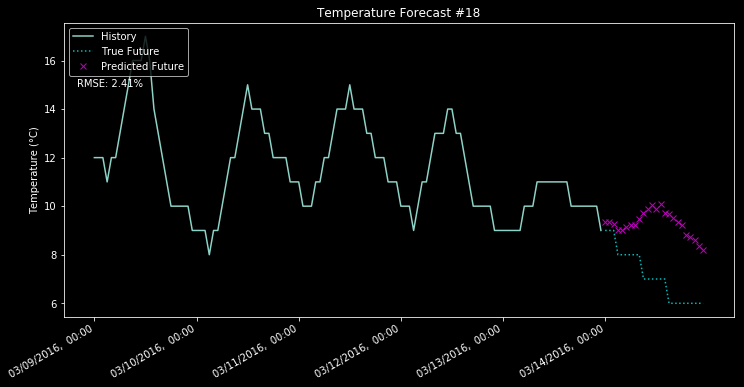

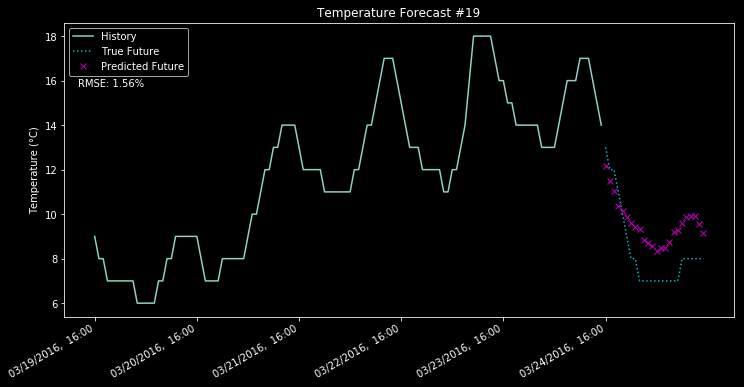

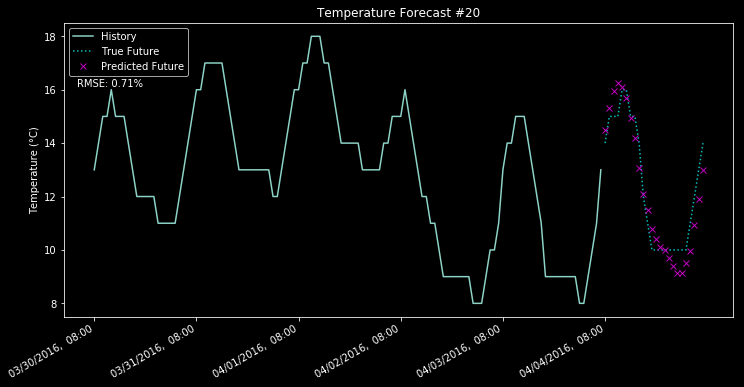

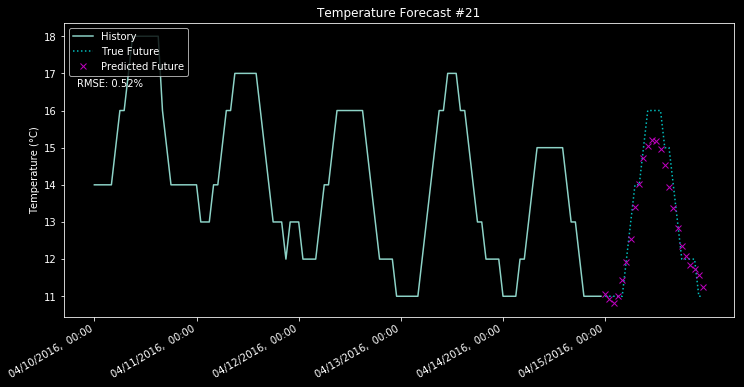

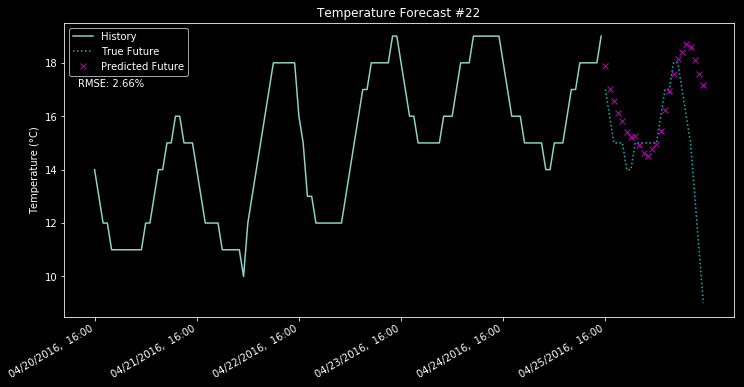

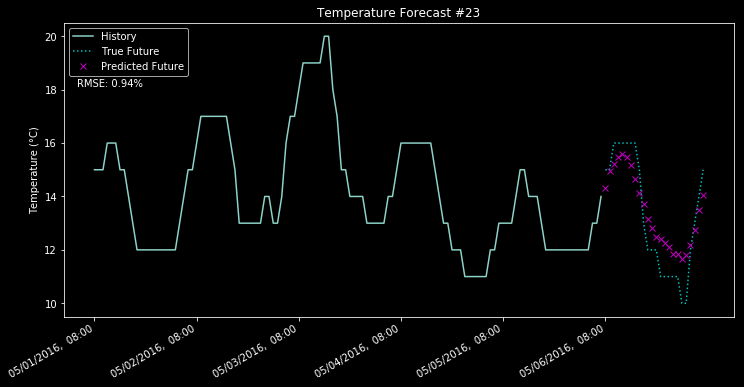

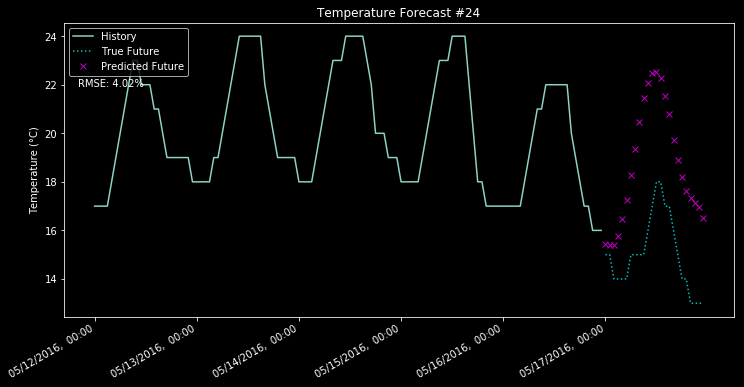

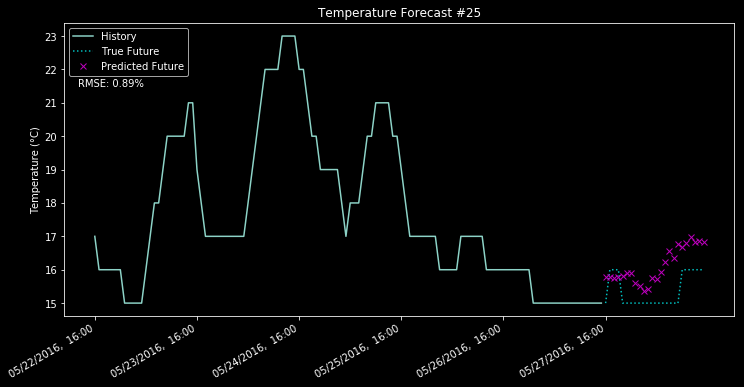

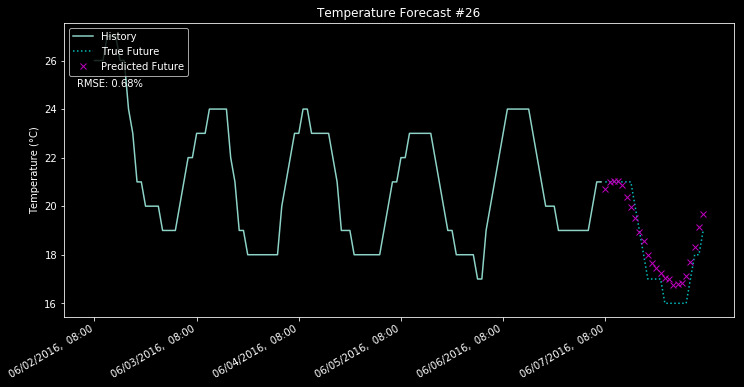

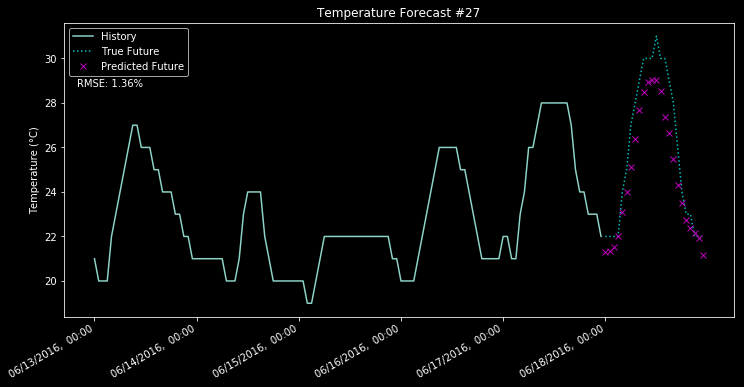

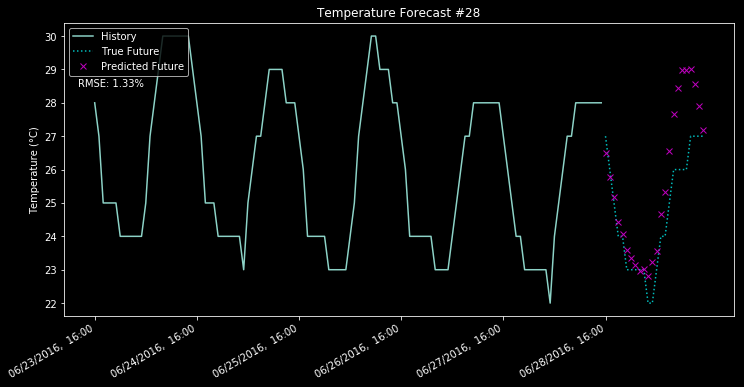

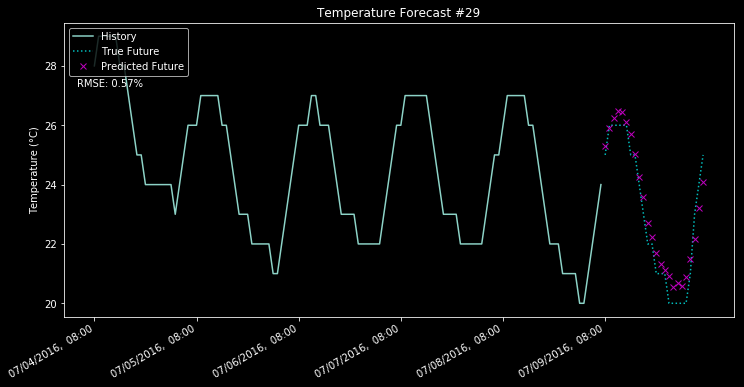

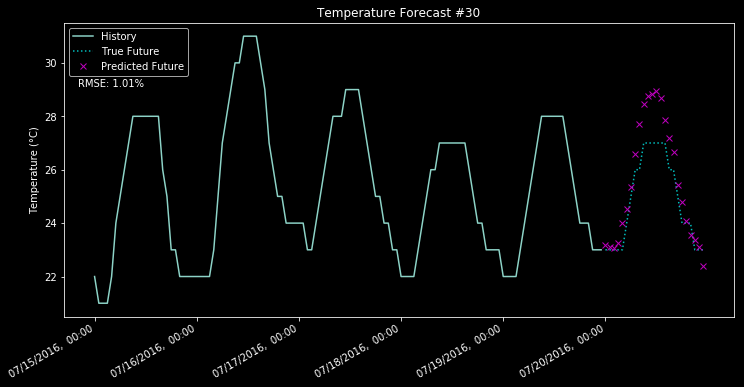

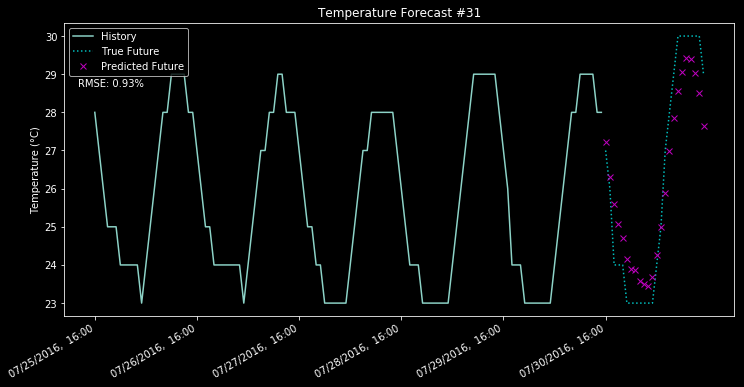

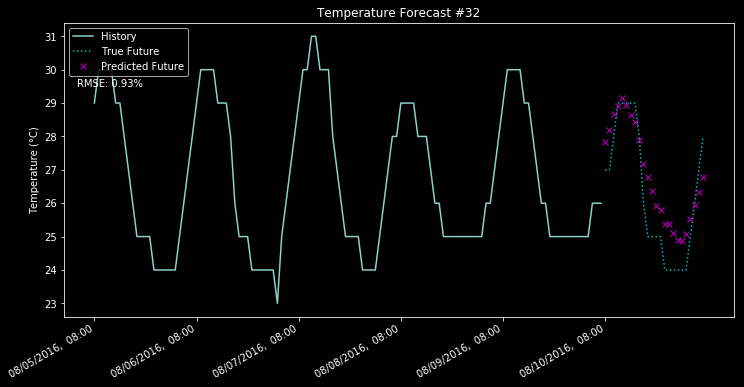

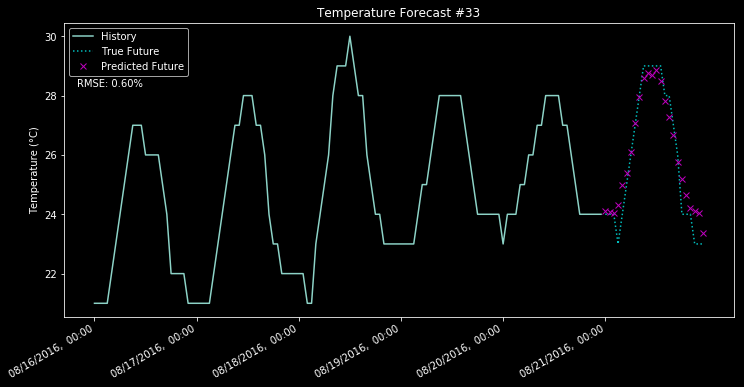

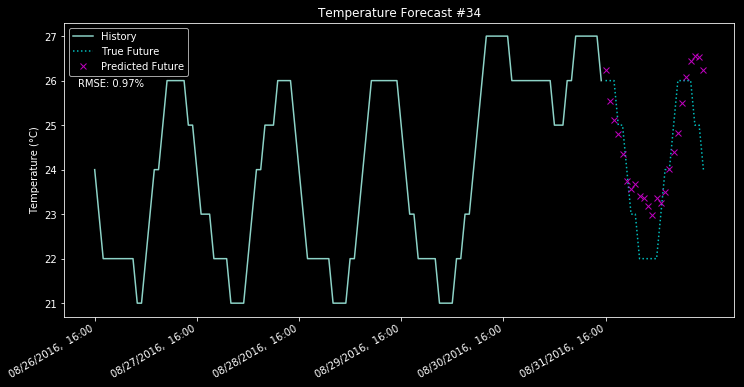

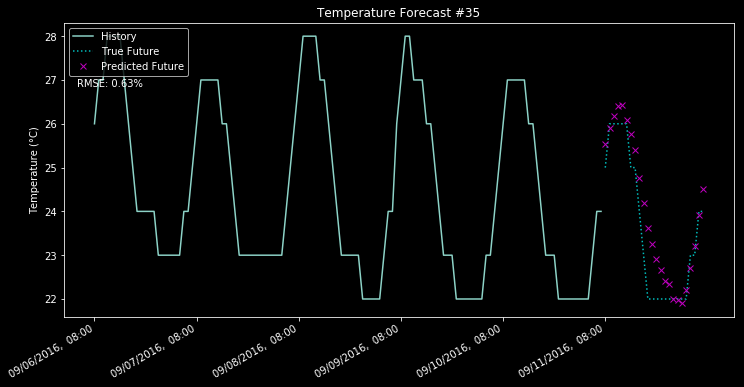

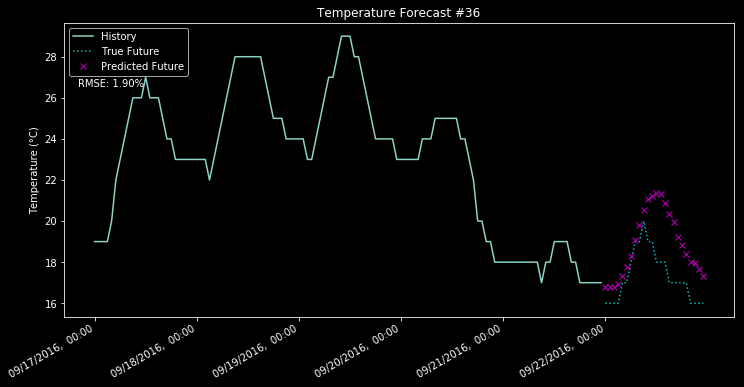

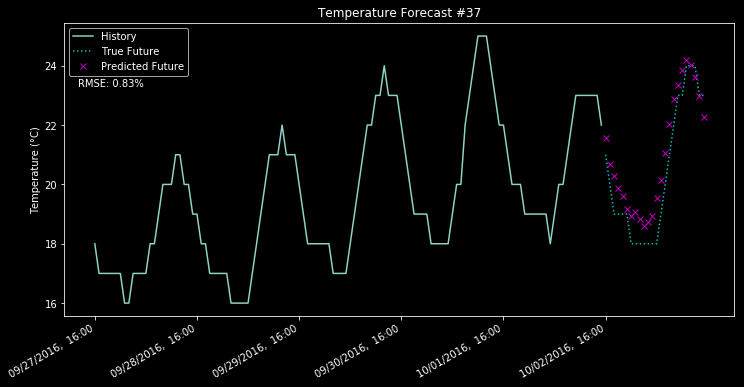

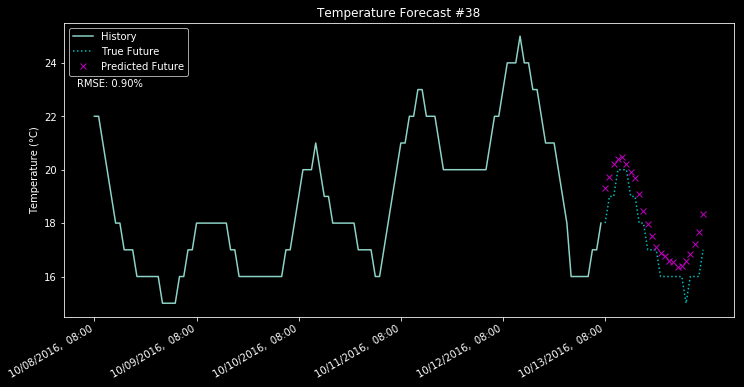

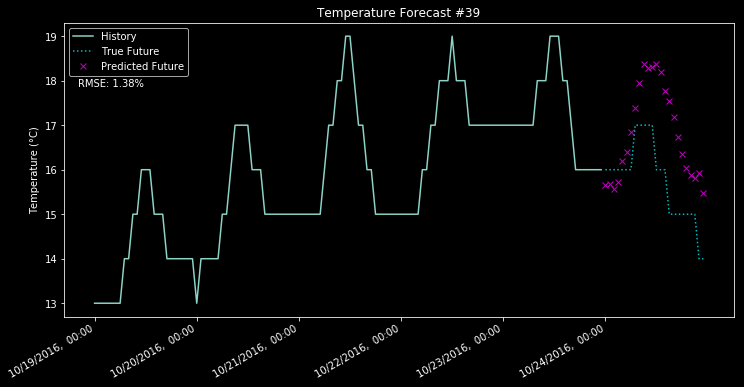

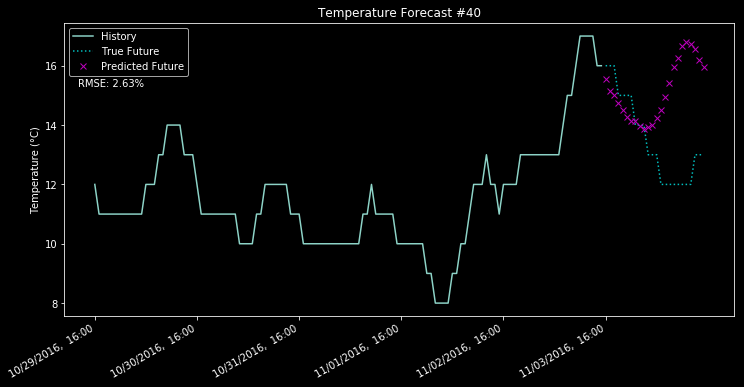

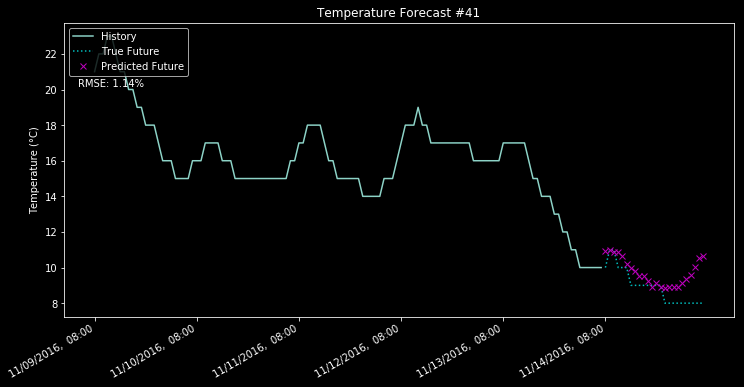

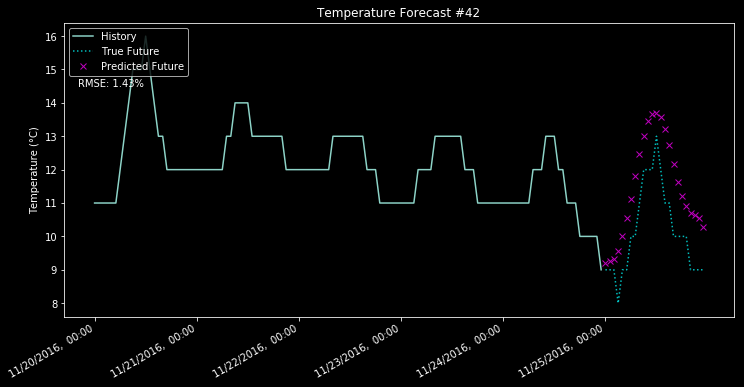

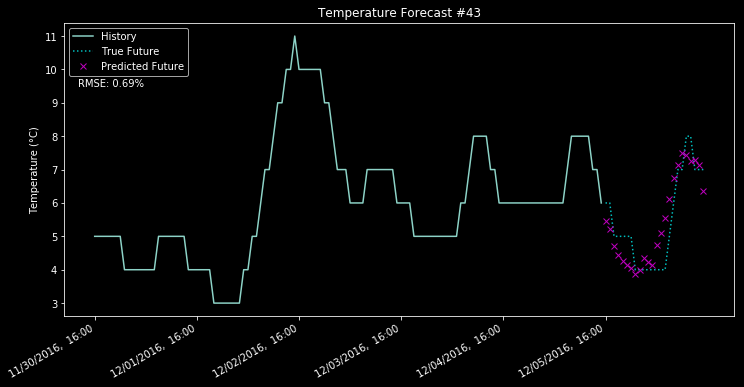

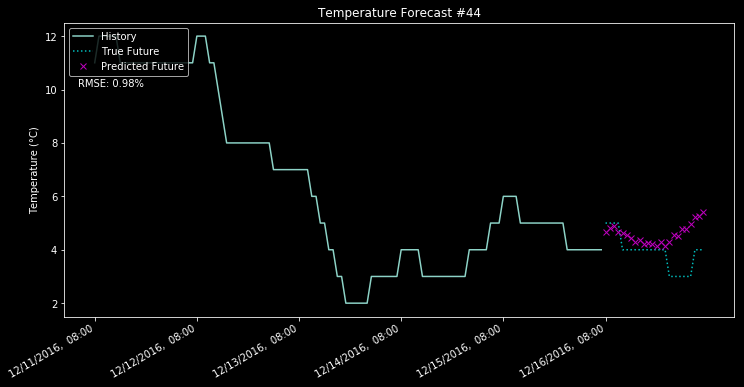

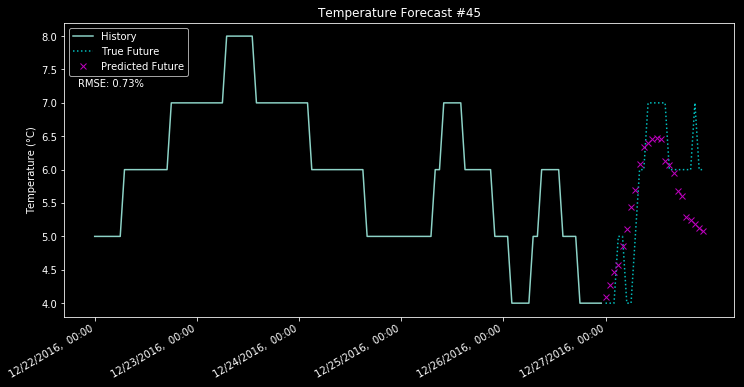

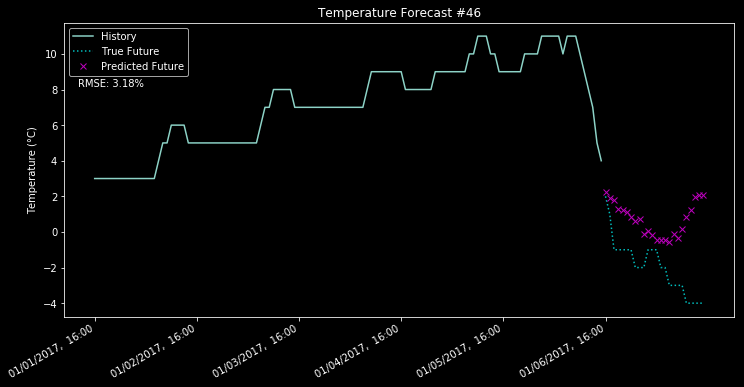

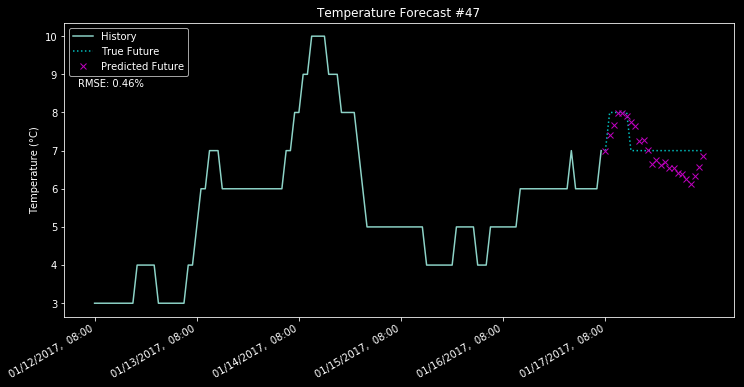

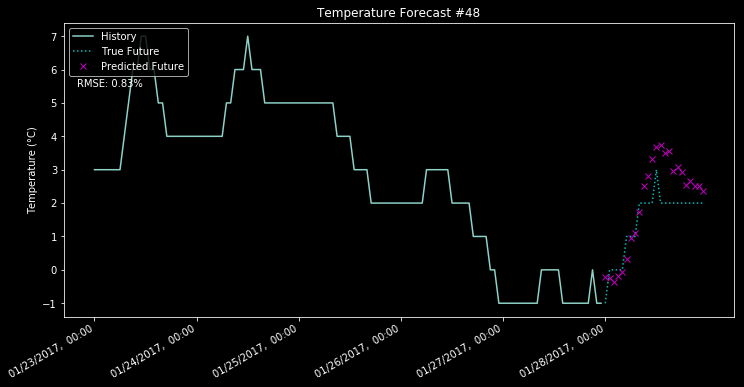

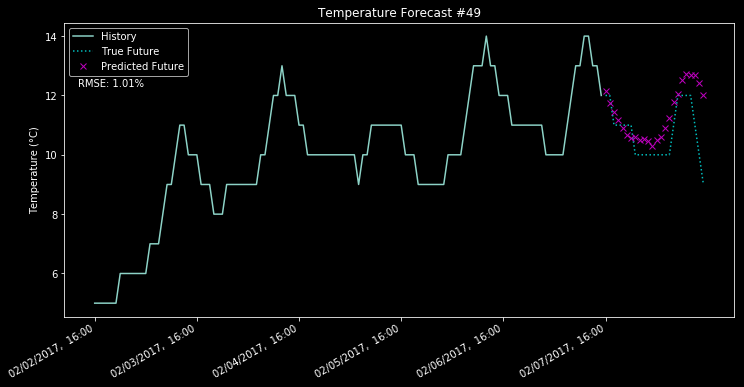

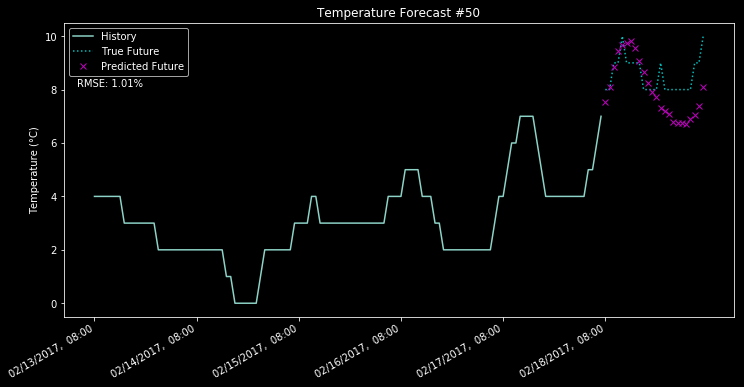

In [0]:
from sklearn.metrics import mean_squared_error
from matplotlib.ticker import FormatStrFormatter
from math import sqrt

# Keep track of iterations and specify the number of predictions to be made.
iter_num = -1
NUMBER_OF_PREDICTIONS = 50;

for x, y in test_data.take(NUMBER_OF_PREDICTIONS): 
  
  iter_num = iter_num + 1
  
  # Unscale history.
  history = scaler.inverse_transform(x[0].numpy())
  
  # Unscale true future.
  ground_truth = np.transpose(np.insert(np.zeros([features.shape[1]-1,future]),1,y[0],0))
  ground_truth = scaler.inverse_transform(ground_truth)[:,1]
  
  # Unscale forecasted values.
  prediction = np.transpose(np.insert(np.zeros([features.shape[1]-1,future]),1,model.predict(x)[0],0))
  prediction = scaler.inverse_transform(prediction)[:,1]
  
  # Calculate RMSE.
  rmse = sqrt(mean_squared_error(ground_truth,prediction))
    
  # Plot the graph.
  fig, ax = plt.subplots(figsize=(12,6))
  timeframe = np.arange(len(history[:,1]),len(history[:,1])+len(ground_truth))
  plt.plot(range(len(history[:,1])),
           np.array(history[:,1]),
           label='History')
  plt.plot(timeframe, 
           np.array(ground_truth), 'c:', 
           label='True Future')
  plt.plot(timeframe, 
           np.array(prediction), 'mx',
           label='Predicted Future')
  fig.autofmt_xdate() # Rotate the x-labels so that they don't overlap.
  plt.xticks(np.arange(len(history)+len(ground_truth),step=future),
             features.iloc[indices[iter_num*BATCH_SIZE]].index.values.astype("str"))
  plt.legend(loc='upper left')
  plt.ylabel("Temperature (°C)")
  plt.title("Temperature Forecast #"+str(iter_num+1))
  ax.grid(False) # Remove the grid.
  plt.text(0.02,0.81,"RMSE: %.2f%%" % rmse,
           ha='left', va='top',
           transform=ax.transAxes)
  
  plt.show()

The forecasts look pretty close to reality in general, meaning that we have reached our goal at this point. Finally, it is time to save our model, so that we can apply it to new data if we want to. 


In [0]:
# Save the model to a desired path.
model.save("istanbul_weather_model.h5")

## Conclusion <a name="conclusion"></a>

In this notebook, we have used weather data to train a model which is able to predict the temperature in Istanbul city, 24 hours into the future. A similar approach can be used for other time series data which resemble the one in our case, for example stock prices. 

We have deployed our model on Github so that other programmers can download it and try to use it, improve it if they can. You are very welcome to ask any questions involving this project via email. We are also open to any corrections; whether it's a typo, misinformation, or a bug. Thank you for your time and focus. See you in another Machine Learning tutorial! 